### File Loads & Text Scraping

In [66]:
#Package imports
from bs4 import BeautifulSoup
import pandas as pd
import time
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from googlesearch import search
import yfinance as yf #this requires a package adjustment to work (yikes)
sns.set_style('darkgrid')

In [2]:
#Pulling files from local repo (ideally I'll be able to figure out automating this at some point)
files = os.listdir('/Users/BrandonToushan/Desktop/13f')
print(files)

['TWOSIGMA_Q3_2020.htm', 'CPP_Q3_2020.htm', 'ICAHN_CARL_Q3_2020.htm', '.DS_Store', 'CORNERSTONE_Q3_2020.htm', 'DESHAW_Q3_2020.htm', 'BAUPOST_Q3_2020.htm', 'RENAISSANCE_Q3_2020.htm', 'VIKING_Q3_2020.htm', 'TCI_Q3_2020.htm', 'TIGER_Q3_2020.htm', 'BRIDGEWATER_Q3_2020.htm', 'LONEPINE_Q3_2020.htm', 'POINT72_Q3_2020.htm']


In [3]:
#Function to scrape 13f files
def scrape_13f(file):
    date = file
    html = open("/Users/BrandonToushan/Desktop/13f/"+file).read()
    soup = BeautifulSoup(html, 'lxml')
    rows = soup.find_all('tr')[11:]
    positions = []
    for row in rows:
        dic = {}
        position = row.find_all('td')
        dic["NAME_OF_ISSUER"] = position[0].text
        dic["TITLE_OF_CLASS"] = position[1].text
        dic["CUSIP"] = position[2].text
        dic["VALUE"] = int(position[3].text.replace(',', ''))*1000
        dic["SHARES"] = int(position[4].text.replace(',', ''))
        dic["DATE"] = date.strip(".html")
        positions.append(dic)
        
    df = pd.DataFrame(positions)
    return df

### Two Sigma

In [4]:
#Scraping 13f and displaying resulting df
two_sigma_df = scrape_13f(files[0])
two_sigma_df.head()

,NAME_OF_ISSUER,TITLE_OF_CLASS,CUSIP,VALUE,SHARES,DATE
0,2U INC,COM,90214J101,30621000,806652,TWOSIGMA_Q3_2020
1,2U INC,COM,90214J101,934000,24600,TWOSIGMA_Q3_2020
2,2U INC,COM,90214J101,957000,25200,TWOSIGMA_Q3_2020
3,3-D SYS CORP DEL,COM NEW,88554D205,925000,132301,TWOSIGMA_Q3_2020
4,360 FINANCE INC,ADS,88557W101,1248000,116500,TWOSIGMA_Q3_2020


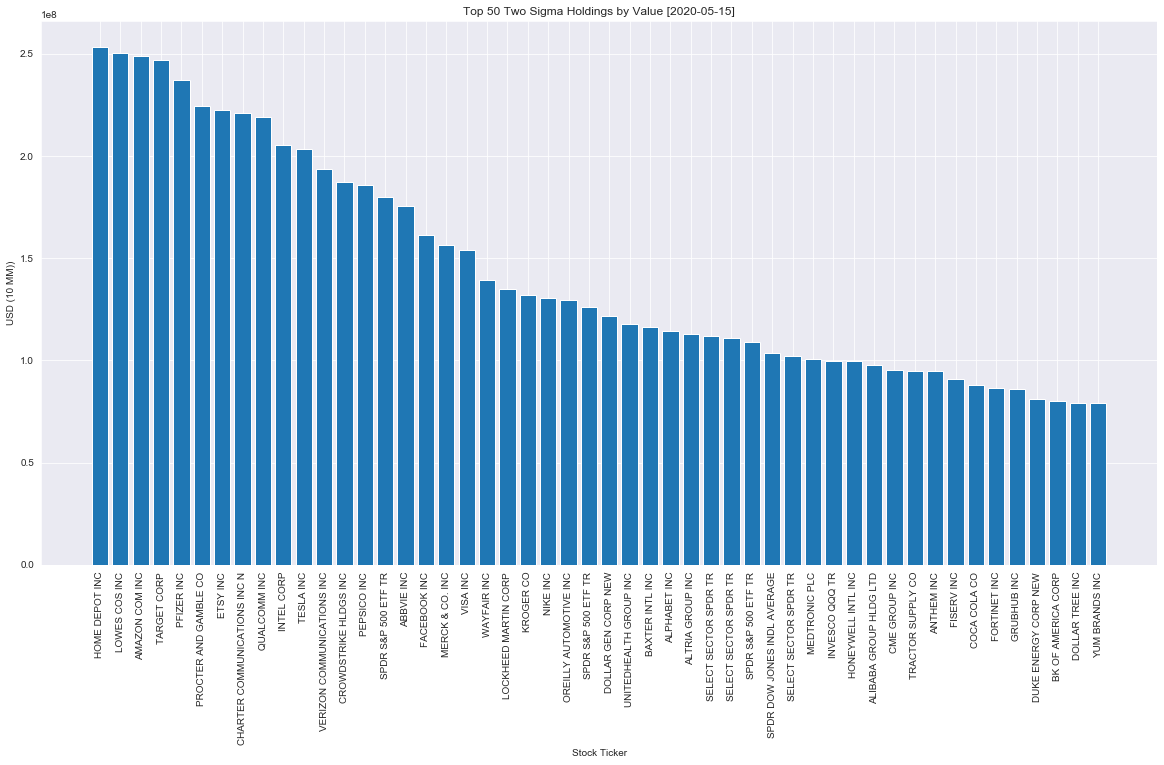

In [137]:
#Extracting top 50 holdings by value
top_50_two_sigma = two_sigma_df.sort_values(by="VALUE", ascending=False)[["NAME_OF_ISSUER","VALUE"]][:50]
a = top_50_two_sigma.NAME_OF_ISSUER
b = top_50_two_sigma.VALUE
c = range(len(b))

#Visualizing top 50 holdings
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.bar(c, b)

plt.xticks(c, a, rotation=90);
plt.title('Top 50 Two Sigma Holdings by Value [2020-05-15]');
plt.xlabel('Stock Ticker');
plt.ylabel('USD (10 MM))');
plt.show();

### Extracting Tickers & Financials

In [55]:
#Function to convert company names to tickers
def ticker_convert(self):
    searchval = 'yahoo finance '+self
    link = []
    #limits to the first link
    for url in search(searchval, tld='es', lang='es', stop=1):
        link.append(url)
    link = str(link[0])
    link=link.split("/")
    if link[-1]=='':
        ticker=link[-2]
    else:
        x=link[-1].split('=')
        ticker=x[-1]
    return(ticker)

#Function converts arrays of names into arrays of tickers using name_convert
def ticker_array_convert(self):
    ticker_list = []
    for i in self:
        val = ticker_convert(i)
        ticker_list.append(val)
    return(ticker_list)

#Function uses yfinance package to pull forward PE values from yahoo finance
def company_PE_data(self):
    company = yf.Ticker(self)
    info = company.info
    forwardPE = info['forwardPE']
    return forwardPE

#Function pulls company_data func to pull forward PE values for an array of tickers
def array_PE_data(self):
    PE_list = []
    for i in self:
        val = company_PE_data(i)
        PE_list.append(val)
    return(PE_list)

### Forward P/E Ratio for Two Sigma's Top 30 Holdings 

In [57]:
#Extracting tickers for Two Sigma's top 30 holdings
top_30_two_sigma_df = two_sigma_df.sort_values(by="VALUE", ascending=False)[["NAME_OF_ISSUER","VALUE"]][:31]
top_30_two_sigma = list(top_30_two_sigma_df.NAME_OF_ISSUER)
top_30_two_sigma_tickers = ticker_array_convert(top_30_two_sigma)

#Pulling in trailing PE values for Two Sigma's top 30 holdings
top_30_two_sigma_PE_vals = array_PE_data(top_30_two_sigma_tickers)

In [134]:
#Formatting PE_vals as a dfs
top_30_two_sigma_PE_vals_df = pd.DataFrame( top_30_two_sigma_PE_vals,columns=['PE_RATIO'])

#Reseting df indices
top_30_two_sigma_PE_vals_df.reset_index(drop=True, inplace=True)
top_30_two_sigma_df.reset_index(drop=True, inplace=True)

#Concatenating the two dfs, dropping holdings with NaN P/E Ratios
top_30_two_sigma_complete_df = pd.concat([top_30_two_sigma_df,top_30_two_sigma_PE_vals_df],axis=1)
top_30_two_sigma_complete_df.dropna();
top_30_two_sigma_complete_df.describe()

,VALUE,PE_RATIO
count,3.100000e+01,28.000000
mean,1.746561e+08,60.507033
std,4.850734e+07,124.772664
min,1.120030e+08,7.911497
25%,1.300890e+08,14.480997
50%,1.756690e+08,22.541170
75%,2.200775e+08,31.810700
max,2.533770e+08,563.684200


### Visualizing Results

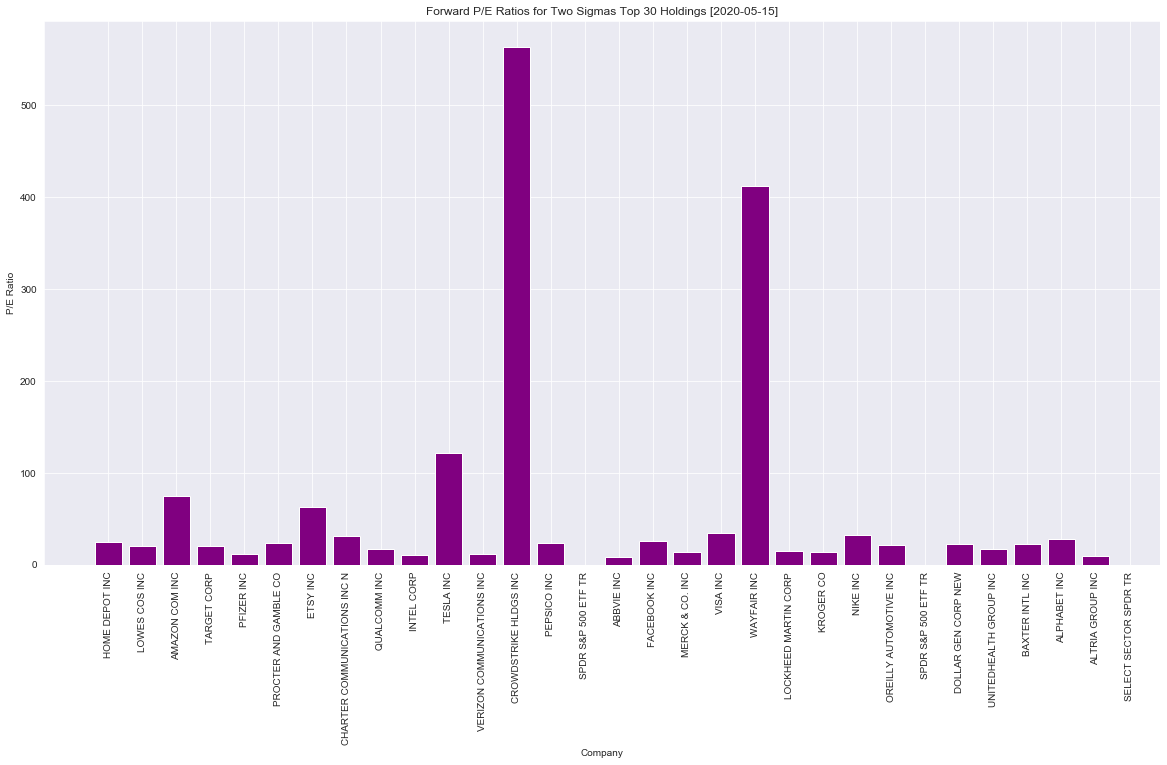

In [136]:
#Visualizing top 30 holdings
a = top_30_two_sigma_complete_df.NAME_OF_ISSUER
b = top_30_two_sigma_complete_df.PE_RATIO
c = range(len(b))

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.bar(c, b,color ='purple')

plt.xticks(c, a, rotation=90);
plt.title('Forward P/E Ratios for Two Sigmas Top 30 Holdings [2020-05-15]');
plt.xlabel('Company');
plt.ylabel('P/E Ratio');
plt.show();